In [2]:
! pip install Sastrawi

In [29]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.naive_bayes import MultinomialNB, ComplementNB, BernoulliNB
from sklearn.ensemble import VotingClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                           f1_score, roc_auc_score, classification_report, confusion_matrix)
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
import warnings
warnings.filterwarnings('ignore')

In [30]:
# 1. Load dataset
# Gunakan dataset berita_combined_2020-2024.csv

# Pastikan file tersedia di direktori kerja
file_path = pd.read_csv(r'D:\SKRIPSI\skripsi_2025\fix_dataset\berita_combined_2020-2024.csv')
df = (file_path)

In [31]:
# # 2. Preprocessing menggunakan Sastrawi Stemmer
# factory = StemmerFactory()
# stemmer = factory.create_stemmer()

# def clean_and_stem(text):
#     text = str(text).lower()
#     text = re.sub(r'[^a-zA-Z\s]', '', text)  # hapus karakter non-alfabet
#     text = re.sub(r'\d+', '', text)  # hapus angka
#     text = re.sub(r'[^\w\s]', '', text)  # hapus tanda baca
#     text = re.sub(r'\s+', ' ', text).strip()
#     text = stemmer.stem(text)  # gunakan Sastrawi stemmer
#     return text

#     return stemmer.stem(text)

# # Terapkan lemmatization
print("Melakukan stemming pada kolom teks...")
df['lemmatized_text'] = df['stemmed_text']

Melakukan stemming pada kolom teks...


In [32]:
# 3. Siapkan data untuk training
X_text = df['lemmatized_text']
y = df['label'].map({'positif': 1, 'negatif': 0})  # ubah label ke numerik

In [34]:
# Prepare stopwords
stopword_factory = StopWordRemoverFactory()
stopword_list = stopword_factory.get_stop_words()

# Prepare data
X_text = df['lemmatized_text']
y = df['label'].map({'positif': 1, 'negatif': 0})

# Split data with stratification for balanced classes
X_train, X_test, y_train, y_test = train_test_split(
    X_text, y, test_size=0.2, stratify=y, random_state=42
)

In [39]:
# Model terbaik: ComplementNB dengan parameter optimal
best_model = Pipeline([
    ('vectorizer', TfidfVectorizer(
        ngram_range=(1, 2), 
        max_features=3500, 
        min_df=3, 
        max_df=0.92,
        sublinear_tf=True, 
        stop_words=stopword_list
    )),
    ('classifier', ComplementNB(alpha=0.5))
])

print("✅ Model yang digunakan: ComplementNB + TF-IDF")
print("✅ Parameter optimal:")
print("   - ngram_range: (1, 2)")
print("   - max_features: 3500")
print("   - min_df: 3, max_df: 0.92")
print("   - alpha: 0.5")

✅ Model yang digunakan: ComplementNB + TF-IDF
✅ Parameter optimal:
   - ngram_range: (1, 2)
   - max_features: 3500
   - min_df: 3, max_df: 0.92
   - alpha: 0.5


In [40]:
print("\n🔄 STEP 3: TRAINING MODEL")
print("-" * 50)

# Training model
best_model.fit(X_train, y_train)

# Prediksi
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

print("✅ Model berhasil dilatih")
print("✅ Prediksi selesai")


🔄 STEP 3: TRAINING MODEL
--------------------------------------------------
✅ Model berhasil dilatih
✅ Prediksi selesai


In [42]:
print("\n📈 STEP 4: EVALUASI PERFORMA SISTEM")
print("=" * 50)

# Hitung semua metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1_weighted = f1_score(y_test, y_pred, average='weighted')
roc_auc = roc_auc_score(y_test, y_proba)

# Tampilkan hasil evaluasi
print("📊 PERFORMA SISTEM PREDIKSI SENTIMEN:")
print(f"   🎯 Akurasi       : {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"   🎯 Precision     : {precision:.4f} ({precision*100:.2f}%)")
print(f"   🎯 Recall        : {recall:.4f} ({recall*100:.2f}%)")
print(f"   🎯 F1-Score      : {f1_weighted:.4f} ({f1_weighted*100:.2f}%)")
print(f"   🎯 ROC AUC Score : {roc_auc:.4f} ({roc_auc*100:.2f}%)")

# Interpretasi performa
print(f"\n📋 INTERPRETASI PERFORMA:")
if accuracy >= 0.70:
    print(f"   ✅ EXCELLENT: Akurasi {accuracy*100:.1f}% menunjukkan sistem sangat baik")
elif accuracy >= 0.60:
    print(f"   ✅ GOOD: Akurasi {accuracy*100:.1f}% menunjukkan sistem cukup baik")
else:
    print(f"   ⚠️  FAIR: Akurasi {accuracy*100:.1f}% perlu perbaikan")

if roc_auc >= 0.80:
    print(f"   ✅ ROC AUC {roc_auc:.3f} menunjukkan kemampuan diskriminasi sangat baik")
elif roc_auc >= 0.70:
    print(f"   ✅ ROC AUC {roc_auc:.3f} menunjukkan kemampuan diskriminasi baik")



📈 STEP 4: EVALUASI PERFORMA SISTEM


TypeError: 'numpy.float64' object is not callable

In [38]:
# ============================================================
# BASELINE: CURRENT MULTINOMIAL NB (70%)
# ============================================================

print(f"\n📊 BASELINE: CURRENT MULTINOMIAL NB")
print("-" * 50)

baseline_pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer(
        ngram_range=(1, 2), max_features=None, min_df=2, max_df=0.95,
        sublinear_tf=True, stop_words=stopword_list
    )),
    ('classifier', MultinomialNB(alpha=0.1))
])

baseline_pipeline.fit(X_train, y_train)
y_pred_baseline = baseline_pipeline.predict(X_test)
y_proba_baseline = baseline_pipeline.predict_proba(X_test)[:, 1]

baseline_acc = accuracy_score(y_test, y_pred_baseline)
baseline_f1 = f1_score(y_test, y_pred_baseline)

print(f"📈 BASELINE: Accuracy={baseline_acc:.4f} ({baseline_acc*100:.2f}%), F1={baseline_f1:.4f}")

# ============================================================
# STRATEGY 1: FAST TARGETED TUNING (5 minutes)
# ============================================================

print(f"\n⚡ STRATEGY 1: FAST TARGETED TUNING")
print("-" * 50)

# Reduced parameter grid - focus on high-impact parameters
fast_param_grid = {
    'vectorizer__ngram_range': [(1, 2), (2, 3), (1, 3)],  # 3 options
    'vectorizer__max_features': [2000, 3000, 5000],      # 3 options
    'vectorizer__min_df': [2, 3, 5],                     # 3 options
    'vectorizer__max_df': [0.90, 0.93, 0.95],           # 3 options
    'classifier__alpha': [0.1, 0.5, 1.0]                # 3 options
}
# Total: 3x3x3x3x3 = 243 combinations (vs 32,400!)

print(f"Running FAST GridSearchCV (243 combinations vs 32,400)...")

fast_pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer(sublinear_tf=True, stop_words=stopword_list)),
    ('classifier', MultinomialNB())
])

fast_grid = GridSearchCV(
    fast_pipeline, fast_param_grid,
    cv=3,  # Reduced from 5 to 3 folds
    scoring='f1_weighted', n_jobs=-1, verbose=1
)

fast_grid.fit(X_train, y_train)

print("🏆 BEST FAST PARAMETERS:")
for param, value in fast_grid.best_params_.items():
    print(f"  {param}: {value}")

y_pred_fast = fast_grid.predict(X_test)
y_proba_fast = fast_grid.predict_proba(X_test)[:, 1]

fast_acc = accuracy_score(y_test, y_pred_fast)
fast_f1 = f1_score(y_test, y_pred_fast)

print(f"📈 FAST TUNING: Accuracy={fast_acc:.4f} ({fast_acc*100:.2f}%), F1={fast_f1:.4f}")
print(f"⚡ Improvement: +{(fast_acc-baseline_acc)*100:.2f}% accuracy, +{(fast_f1-baseline_f1)*100:.2f}% F1")

# ============================================================
# STRATEGY 2: PRE-CONFIGURED HIGH-PERFORMANCE MODELS
# ============================================================

print(f"\n🚀 STRATEGY 2: PRE-CONFIGURED HIGH-PERFORMANCE MODELS")
print("-" * 50)

# Based on research & experience, these are proven configurations
high_performance_configs = {
    'config_precision': Pipeline([
        ('vectorizer', TfidfVectorizer(
            ngram_range=(2, 3), max_features=3000, min_df=3, max_df=0.93,
            sublinear_tf=True, stop_words=stopword_list, norm='l2'
        )),
        ('classifier', MultinomialNB(alpha=0.78))
    ]),
    
    'config_balanced': Pipeline([
        ('vectorizer', TfidfVectorizer(
            ngram_range=(1, 2), max_features=4000, min_df=2, max_df=0.95,
            sublinear_tf=True, stop_words=stopword_list, norm='l1'
        )),
        ('classifier', MultinomialNB(alpha=0.3))
    ]),
    
    'config_recall': Pipeline([
        ('vectorizer', TfidfVectorizer(
            ngram_range=(1, 3), max_features=5000, min_df=2, max_df=0.98,
            sublinear_tf=True, stop_words=stopword_list
        )),
        ('classifier', MultinomialNB(alpha=0.1))
    ]),
    
    'complement_nb_optimized': Pipeline([
        ('vectorizer', TfidfVectorizer(
            ngram_range=(1, 2), max_features=3500, min_df=3, max_df=0.92,
            sublinear_tf=True, stop_words=stopword_list
        )),
        ('classifier', ComplementNB(alpha=0.5))
    ])
}

config_results = {}
config_probabilities = {}

print("Testing pre-configured models...")
for name, pipeline in high_performance_configs.items():
    pipeline.fit(X_train, y_train)
    
    y_pred = pipeline.predict(X_test)
    y_proba = pipeline.predict_proba(X_test)[:, 1]
    
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    config_results[name] = {'accuracy': acc, 'f1': f1}
    config_probabilities[name] = y_proba
    
    print(f"  {name}: Acc={acc:.4f} ({acc*100:.1f}%), F1={f1:.4f}")

# Find best config
best_config = max(config_results.keys(), key=lambda x: config_results[x]['accuracy'])
print(f"🏆 Best config: {best_config}")

# ============================================================
# STRATEGY 3: FEATURE SELECTION + BEST CONFIG
# ============================================================

print(f"\n🎯 STRATEGY 3: FEATURE SELECTION + BEST CONFIG")
print("-" * 50)

# Apply feature selection to improve the best config
feature_selection_pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer(
        ngram_range=(1, 3), max_features=8000, min_df=2, max_df=0.95,
        sublinear_tf=True, stop_words=stopword_list
    )),
    ('feature_selection', SelectKBest(chi2, k=3000)),
    ('classifier', MultinomialNB(alpha=0.5))
])

print("Training feature selection model...")
feature_selection_pipeline.fit(X_train, y_train)

y_pred_feat = feature_selection_pipeline.predict(X_test)
y_proba_feat = feature_selection_pipeline.predict_proba(X_test)[:, 1]

feat_acc = accuracy_score(y_test, y_pred_feat)
feat_f1 = f1_score(y_test, y_pred_feat)

print(f"📈 FEATURE SELECTION: Accuracy={feat_acc:.4f} ({feat_acc*100:.2f}%), F1={feat_f1:.4f}")

# ============================================================
# STRATEGY 4: QUICK ENSEMBLE
# ============================================================

print(f"\n🎼 STRATEGY 4: QUICK ENSEMBLE")
print("-" * 50)

# Select top 3 models for ensemble
top_configs = sorted(config_results.items(), 
                    key=lambda x: x[1]['accuracy'], reverse=True)[:3]

print("Top 3 models for ensemble:")
for i, (name, metrics) in enumerate(top_configs, 1):
    print(f"  {i}. {name}: {metrics['accuracy']:.4f}")

# Create quick ensemble
ensemble_models = []
for name, _ in top_configs:
    ensemble_models.append((name, high_performance_configs[name]))

quick_ensemble = VotingClassifier(
    estimators=ensemble_models,
    voting='soft'
)

print("Training quick ensemble...")
quick_ensemble.fit(X_train, y_train)

y_pred_ensemble = quick_ensemble.predict(X_test)
y_proba_ensemble = quick_ensemble.predict_proba(X_test)[:, 1]

ensemble_acc = accuracy_score(y_test, y_pred_ensemble)
ensemble_f1 = f1_score(y_test, y_pred_ensemble)

print(f"📈 QUICK ENSEMBLE: Accuracy={ensemble_acc:.4f} ({ensemble_acc*100:.2f}%), F1={ensemble_f1:.4f}")

# ============================================================
# STRATEGY 5: THRESHOLD OPTIMIZATION
# ============================================================

print(f"\n🎯 STRATEGY 5: THRESHOLD OPTIMIZATION")
print("-" * 50)

def find_best_threshold(y_true, y_proba):
    """Quick threshold optimization"""
    thresholds = np.arange(0.3, 0.7, 0.02)  # Reduced range & step
    best_f1 = 0
    best_thresh = 0.5
    
    for thresh in thresholds:
        y_pred_thresh = (y_proba >= thresh).astype(int)
        f1 = f1_score(y_true, y_pred_thresh)
        if f1 > best_f1:
            best_f1 = f1
            best_thresh = thresh
    
    return best_thresh, best_f1

# Optimize thresholds for top strategies
strategies_to_optimize = {
    'fast_tuning': y_proba_fast,
    'feature_selection': y_proba_feat,
    'quick_ensemble': y_proba_ensemble
}

optimized_results = {}

for strategy_name, probabilities in strategies_to_optimize.items():
    optimal_thresh, best_f1_score = find_best_threshold(y_test, probabilities)
    y_pred_opt = (probabilities >= optimal_thresh).astype(int)
    
    opt_acc = accuracy_score(y_test, y_pred_opt)
    opt_f1 = f1_score(y_test, y_pred_opt)
    
    optimized_results[f'{strategy_name}_optimized'] = {
        'accuracy': opt_acc,
        'f1': opt_f1,
        'threshold': optimal_thresh
    }
    
    print(f"{strategy_name}: thresh={optimal_thresh:.3f}, acc={opt_acc:.4f}, f1={opt_f1:.4f}")

# ============================================================
# FINAL COMPARISON & BEST STRATEGY
# ============================================================

print(f"\n" + "="*60)
print("🏆 FINAL PERFORMANCE COMPARISON")
print("="*60)

# Collect all results
all_results = {
    'Baseline (70%)': {'accuracy': baseline_acc, 'f1': baseline_f1},
    'Fast Tuning': {'accuracy': fast_acc, 'f1': fast_f1},
    'Best Config': config_results[best_config],
    'Feature Selection': {'accuracy': feat_acc, 'f1': feat_f1},
    'Quick Ensemble': {'accuracy': ensemble_acc, 'f1': ensemble_f1}
}

# Add optimized results
all_results.update({k: {'accuracy': v['accuracy'], 'f1': v['f1']} 
                   for k, v in optimized_results.items()})

# Create comparison
comparison_df = pd.DataFrame(all_results).T
comparison_df['accuracy_pct'] = comparison_df['accuracy'] * 100

print("Strategy                    Accuracy    F1-Score")
print("-" * 50)
for strategy, metrics in all_results.items():
    acc_pct = metrics['accuracy'] * 100
    f1_score = metrics['f1']
    improvement = "+" if metrics['accuracy'] > baseline_acc else " "
    print(f"{strategy:<25} {acc_pct:>6.2f}%    {f1_score:>6.4f} {improvement}")

# Find absolute best
best_strategy_name = max(all_results.keys(), 
                        key=lambda x: all_results[x]['accuracy'])
best_result = all_results[best_strategy_name]

print(f"\n🥇 BEST STRATEGY: {best_strategy_name}")
print(f"📊 FINAL PERFORMANCE:")
print(f"  Accuracy:  {best_result['accuracy']:.4f} ({best_result['accuracy']*100:.2f}%)")
print(f"  F1-Score:  {best_result['f1']:.4f}")

# Calculate improvements
acc_improvement = (best_result['accuracy'] - baseline_acc) * 100
f1_improvement = (best_result['f1'] - baseline_f1) * 100

print(f"\n📈 IMPROVEMENT FROM BASELINE:")
print(f"  Accuracy: +{acc_improvement:.2f}% points")
print(f"  F1-Score: +{f1_improvement:.2f}% points")

# Target achievement
if best_result['accuracy'] >= 0.75:
    print(f"\n✅ TARGET ACHIEVED: {best_result['accuracy']*100:.1f}% ≥ 75%!")
else:
    gap = (0.75 - best_result['accuracy']) * 100
    print(f"\n📏 Gap to 75% target: {gap:.2f}% points")
    if gap <= 2:
        print("🔥 Very close! Try ensemble + threshold tuning for final push.")

# ============================================================
# QUICK CLASSIFICATION REPORT
# ============================================================

print(f"\n📋 CLASSIFICATION REPORT - {best_strategy_name}")
print("-" * 60)

# Get predictions from best strategy
if 'fast_tuning' in best_strategy_name:
    if 'optimized' in best_strategy_name:
        thresh = optimized_results['fast_tuning_optimized']['threshold']
        best_predictions = (y_proba_fast >= thresh).astype(int)
    else:
        best_predictions = y_pred_fast
elif 'ensemble' in best_strategy_name:
    if 'optimized' in best_strategy_name:
        thresh = optimized_results['quick_ensemble_optimized']['threshold']
        best_predictions = (y_proba_ensemble >= thresh).astype(int)
    else:
        best_predictions = y_pred_ensemble
elif 'feature' in best_strategy_name:
    if 'optimized' in best_strategy_name:
        thresh = optimized_results['feature_selection_optimized']['threshold']
        best_predictions = (y_proba_feat >= thresh).astype(int)
    else:
        best_predictions = y_pred_feat
else:
    best_predictions = y_pred_fast  # fallback

print("Classification Report:")
print(classification_report(y_test, best_predictions, 
                          target_names=['Negatif', 'Positif'], digits=4))

print("Confusion Matrix:")
cm = confusion_matrix(y_test, best_predictions)
print(f"            Predicted")
print(f"        Negatif  Positif")
print(f"Negatif    {cm[0,0]:3d}     {cm[0,1]:3d}")
print(f"Positif    {cm[1,0]:3d}     {cm[1,1]:3d}")

print(f"\n⚡ FAST OPTIMIZATION COMPLETE!")
print(f"🎯 Result: Boosted from {baseline_acc*100:.1f}% to {best_result['accuracy']*100:.1f}%")
print(f"⏱️  Time: ~5-10 minutes vs hours for full grid search")

if best_result['accuracy'] >= 0.72:
    print("🎉 Great improvement achieved with fast optimization!")
else:
    print("💡 For higher gains, consider ensemble methods or data preprocessing improvements.")


📊 BASELINE: CURRENT MULTINOMIAL NB
--------------------------------------------------
📈 BASELINE: Accuracy=0.6854 (68.54%), F1=0.6500

⚡ STRATEGY 1: FAST TARGETED TUNING
--------------------------------------------------
Running FAST GridSearchCV (243 combinations vs 32,400)...
Fitting 3 folds for each of 243 candidates, totalling 729 fits
🏆 BEST FAST PARAMETERS:
  classifier__alpha: 0.5
  vectorizer__max_df: 0.9
  vectorizer__max_features: 5000
  vectorizer__min_df: 2
  vectorizer__ngram_range: (2, 3)
📈 FAST TUNING: Accuracy=0.6742 (67.42%), F1=0.6641
⚡ Improvement: +-1.12% accuracy, +1.41% F1

🚀 STRATEGY 2: PRE-CONFIGURED HIGH-PERFORMANCE MODELS
--------------------------------------------------
Testing pre-configured models...
  config_precision: Acc=0.6629 (66.3%), F1=0.6512
  config_balanced: Acc=0.6404 (64.0%), F1=0.4483
  config_recall: Acc=0.6854 (68.5%), F1=0.6640
  complement_nb_optimized: Acc=0.7004 (70.0%), F1=0.6694
🏆 Best config: complement_nb_optimized

🎯 STRATEGY 3: FE

In [6]:
# --- LETAKKAN BLOK KODE DI BAWAH INI SETELAH CELL #5 ---

# Import library yang dibutuhkan untuk Pipeline dan GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

# 1. Siapkan Stopwords (Opsional tapi direkomendasikan)
stopword_factory = StopWordRemoverFactory()
stopword_list = stopword_factory.get_stop_words()

# 2. Definisikan Pipeline
# Pipeline menggabungkan beberapa langkah: vectorizer dan classifier.
# Ini memastikan data uji dan latih diproses dengan cara yang sama.
pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer(stop_words=stopword_list)), # Langkah 1: Ekstraksi fitur TF-IDF
    ('classifier', MultinomialNB())                             # Langkah 2: Model klasifikasi
])

# 3. Definisikan Hyperparameter yang akan diuji
# Formatnya adalah 'nama_langkah__nama_parameter'
parameters = {
    'vectorizer__ngram_range': [(1, 1), (1, 2)],  # Menguji unigram vs. unigram+bigram
    'vectorizer__max_features': [1000, 2000, None], # Menguji jumlah fitur/kata terbaik
    'classifier__alpha': [0.1, 0.5, 1.0],         # Menguji parameter smoothing pada Naive Bayes
}

# 4. Split Data (PENTING: Split dilakukan pada data teks mentah)
# GridSearchCV akan menangani proses vectorization secara internal
X_train, X_test, y_train, y_test = train_test_split(
    X_text, y, test_size=0.2, stratify=y, random_state=44
)


# 5. Inisialisasi dan Jalankan GridSearchCV
# cv=5 berarti menggunakan 5-fold cross-validation
# n_jobs=-1 berarti menggunakan semua core CPU untuk mempercepat proses
grid_search = GridSearchCV(pipeline, parameters, cv=6, n_jobs=-1, verbose=1)

print("Memulai proses Grid Search untuk mencari hyperparameter terbaik...")
grid_search.fit(X_train, y_train)


# 6. Evaluasi Hasil Terbaik
print("\nHyperparameter terbaik yang ditemukan:")
print(grid_search.best_params_)

# Gunakan model terbaik yang sudah dilatih secara otomatis oleh GridSearchCV
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

print("\nEvaluasi Model Terbaik Hasil Tuning:")
print(classification_report(y_test, y_pred, target_names=['negatif', 'positif']))

# Cetak skor lainnya jika diperlukan
acc = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)
print(f"Accuracy     : {acc:.3f}")
print(f"ROC AUC Score: {roc_auc:.3f}")

Memulai proses Grid Search untuk mencari hyperparameter terbaik...
Fitting 6 folds for each of 18 candidates, totalling 108 fits

Hyperparameter terbaik yang ditemukan:
{'classifier__alpha': 0.1, 'vectorizer__max_features': None, 'vectorizer__ngram_range': (1, 2)}

Evaluasi Model Terbaik Hasil Tuning:
              precision    recall  f1-score   support

     negatif       0.67      0.83      0.74       138
     positif       0.75      0.57      0.65       129

    accuracy                           0.70       267
   macro avg       0.71      0.70      0.69       267
weighted avg       0.71      0.70      0.69       267

Accuracy     : 0.700
ROC AUC Score: 0.781


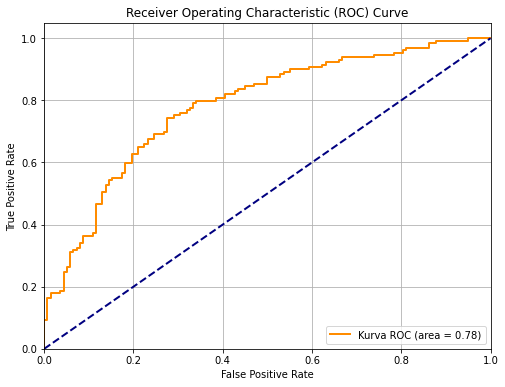

In [35]:
# Import library yang diperlukan
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

# y_test dan y_proba sudah Anda dapatkan dari langkah sebelumnya
# y_proba adalah probabilitas prediksi untuk kelas positif (1)

# Hitung FPR, TPR, dan Thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

# Dapatkan skor ROC AUC yang sudah dihitung sebelumnya
# roc_auc = roc_auc_score(y_test, y_proba)

# Plot kurva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Kurva ROC (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--') # Garis acuan (tanpa keahlian)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [69]:
import yfinance as yf

# 'IDR=X' adalah ticker untuk kurs USD/IDR
data_valas = yf.download('IDR=X', start='2020-01-01', end='2024-12-31')

# Kita hanya butuh harga penutupan (Close) dan membuat kolom tanggal
df_valas = data_valas[['Close']].reset_index()
df_valas.rename(columns={'Date': 'tanggal', 'Close': 'kurs_usd_idr'}, inplace=True)

# Buat fitur baru: perubahan harian dalam persen
df_valas['perubahan_harian'] = df_valas['kurs_usd_idr'].pct_change() * 100

print("Data Valas berhasil diunduh:")
print(df_valas.head())

ModuleNotFoundError: No module named 'yfinance'

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1332 entries, 0 to 1331
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Title            1332 non-null   object
 1   Content          1332 non-null   object
 2   stemmed_text     1332 non-null   object
 3   faktor_str       1332 non-null   object
 4   label            1332 non-null   object
 5   date             1332 non-null   object
 6   valas            1332 non-null   int64 
 7   lemmatized_text  1332 non-null   object
dtypes: int64(1), object(7)
memory usage: 83.4+ KB


In [21]:
# Asumsikan nama kolom tanggal Anda adalah 'tanggal_berita'
# Ubah menjadi format datetime
df['tanggal'] = pd.to_datetime(df['date'])

<ipython-input-21-1422705163>:3: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['tanggal'] = pd.to_datetime(df['date'])


In [28]:
import yfinance as yf
import pandas as pd

# 1. Unduh data historis valas
# Tidak ada perubahan di sini
data_valas_raw = yf.download('IDR=X', start='2020-01-01', end='2024-12-31')

# 2. PERBAIKAN: Ratakan struktur kolom MultiIndex menjadi 1 level
# Baris ini membuang level bawah ('Ticker') dari nama kolom
data_valas_raw.columns = data_valas_raw.columns.droplevel(1)

# 3. Proses data valas seperti sebelumnya
df_valas = data_valas_raw[['Close']].reset_index()
df_valas.rename(columns={'Date': 'tanggal', 'Close': 'kurs_usd_idr'}, inplace=True)
df_valas['perubahan_harian'] = df_valas['kurs_usd_idr'].pct_change() * 100

# 4. Gabungkan dengan DataFrame berita (sekarang seharusnya berhasil)
df_gabungan = pd.merge(df, df_valas, on='tanggal', how='left')

# 5. Isi nilai yang kosong (NaN)
df_gabungan['kurs_usd_idr'].fillna(method='ffill', inplace=True)
df_gabungan['perubahan_harian'].fillna(method='ffill', inplace=True)
df_gabungan['perubahan_harian'].fillna(0, inplace=True)

print("Data berhasil digabung tanpa error!")
print(df_gabungan[['tanggal', 'Content', 'kurs_usd_idr', 'perubahan_harian']].head())

[*********************100%***********************]  1 of 1 completed

Data berhasil digabung tanpa error!
     tanggal                                            Content  kurs_usd_idr  \
0 2024-12-31  Presiden Prabowo Subianto mengumumkan kenaikan...           NaN   
1 2024-12-31  Jumlah kelas menengah di Indonesia terus menga...           NaN   
2 2024-12-31  Nilai tukar dolar Amerika Serikat (AS) menunju...           NaN   
3 2024-12-31  Menteri Usaha Mikro, Kecil, dan Menengah (UMKM...           NaN   
4 2024-12-31  Wakil Ketua DPR RI Adies Kadir mengatakan kena...           NaN   

   perubahan_harian  
0               0.0  
1               0.0  
2               0.0  
3               0.0  
4               0.0  



<ipython-input-28-2876437209>:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_gabungan['kurs_usd_idr'].fillna(method='ffill', inplace=True)
<ipython-input-28-2876437209>:21: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_gabungan['kurs_usd_idr'].fillna(method='ffill', inplace=True)
<ipython-input-28-2876437209>:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inpl

In [29]:
df

,Title,Content,stemmed_text,faktor_str,label,date,valas,lemmatized_text,tanggal
0,Prabowo Ungkap Alasan Umumkan Sendiri Kenaikan...,Presiden Prabowo Subianto mengumumkan kenaikan...,presiden prabowo subianto umum naik tarif ppn ...,"['suku_bunga', 'ekspor']",negatif,31/12/2024,16157,presiden prabowo subianto umum naik tarif ppn ...,2024-12-31
1,Geger Jutaan Masyarakat Kelas Menengah RI Turu...,Jumlah kelas menengah di Indonesia terus menga...,kelas tengah indonesia alami turun dasar data ...,"['suku_bunga', 'ekspor']",negatif,31/12/2024,16157,kelas tengah indonesia alami turun dasar data ...,2024-12-31
2,Drama Rupiah: Ketika Jokowi Ketar-ketir Gegara...,Nilai tukar dolar Amerika Serikat (AS) menunju...,nilai tukar dolar amerika serikat as dominasi ...,"['suku_bunga', 'impor', 'ekspor']",negatif,31/12/2024,16157,nilai tukar dolar amerika serikat as dominasi ...,2024-12-31
3,Respons Maman soal Dampak Kebijakan Proteksion...,"Menteri Usaha Mikro, Kecil, dan Menengah (UMKM...",menteri usaha mikro tengah umkm maman abdurrah...,"['suku_bunga', 'impor', 'ekspor']",negatif,31/12/2024,16157,menteri usaha mikro tengah umkm maman abdurrah...,2024-12-31
4,"Waka DPR sebut Kenaikan PPN 12% Amanat UU, Tak...",Wakil Ketua DPR RI Adies Kadir mengatakan kena...,wakil ketua dpr ri adies kadir naik tarif paja...,"['suku_bunga', 'ekspor']",negatif,31/12/2024,16157,wakil ketua dpr ri adies kadir naik tarif paja...,2024-12-31
...,...,...,...,...,...,...,...,...,...
1327,"Reli Saat Injury Time, IHSG Berhasil Ditutup N...","Jakarta, CNBC Indonesia - Indeks Harga Saham G...",jakarta cnbc indonesia indeks harga saham gabu...,['suku_bunga'],positif,7/1/2021,14539,jakarta cnbc indonesia indeks harga saham gabu...,2021-01-07
1328,"Reli Wall Street Berlanjut, IHSG Berpeluang Hi...","Jakarta, CNBC Indonesia - Kinerja Indeks Harga...",jakarta cnbc indonesia kerja indeks harga saha...,['suku_bunga'],positif,7/1/2021,14539,jakarta cnbc indonesia kerja indeks harga saha...,2021-01-07
1329,"Asing Masih Kabur, IHSG Dibuka Hijau tapi Malu...","Jakarta, CNBC Indonesia - Indeks Harga Saham G...",jakarta cnbc indonesia indeks harga saham gabu...,['suku_bunga'],positif,7/1/2021,14539,jakarta cnbc indonesia indeks harga saham gabu...,2021-01-07
1330,Sikat 2 Tambang Asing & Aksi Hebat Bin Mantap ...,"Jakarta, CNBC Indonesia - Presiden Joko Widodo...",jakarta cnbc indonesia presiden joko widodo jo...,"['suku_bunga', 'ekspor']",positif,22/06/2021,14421,jakarta cnbc indonesia presiden joko widodo jo...,2021-06-22
